In [1]:
import numpy as np
import pandas as pd

import astropy.units as u
from astropy import coordinates, units as u, wcs
from astropy.io.votable import parse
from astropy.table import Table, Column, QTable
from astropy.io import fits
from astropy.visualization import simple_norm

from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from astropy.nddata import CCDData
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon

import warnings

warnings.filterwarnings('ignore')
import importlib 

%matplotlib notebook

import ccdproc

import sys



<IPython.core.display.Javascript object>


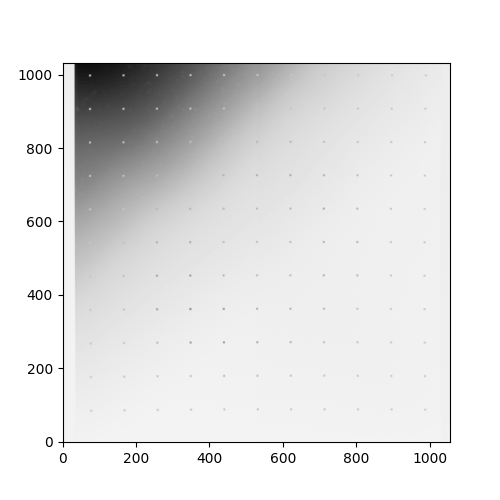

In [12]:
from astropy.stats import mad_std, sigma_clipped_stats
from photutils.detection import IRAFStarFinder, DAOStarFinder
from skimage import util

grid = CCDData.read("../../IMAGES/grid11x11.fits", unit='adu')
flat = CCDData.read("../../IMAGES/flatav.fits", unit='adu')
bias = CCDData.read("../../IMAGES/biasav.fits", unit='adu')
dark = CCDData.read("../../IMAGES/darkav.fits", unit='adu')
dmd = pd.read_csv("../../Slit_Grid 11x11x3.csv").drop(columns=["Unnamed: 0"])

bgrid = ccdproc.subtract_bias(grid,bias)
bflat = ccdproc.subtract_bias(flat, bias)
bdark = ccdproc.subtract_bias(dark, bias)

dbflat = ccdproc.subtract_dark(bflat, bdark, exposure_time=2, exposure_unit='s')
dbgrid = ccdproc.subtract_dark(bgrid, bdark, exposure_time=2, exposure_unit='s')

fdbgrid = ccdproc.flat_correct(dbgrid, dbflat)


fig0 = plt.figure(figsize=(5,5),facecolor=None)
gs0 = GridSpec(figure=fig0,nrows=1,ncols=1)
ax0 = fig0.add_subplot(gs0[0])

invgrid = util.invert(dbgrid)
norm = simple_norm(dbgrid,stretch="log")
ax0.imshow(invgrid,norm=None,cmap="gray", origin='lower')

ax02 = fig0.add_axes([0.5,0.5,0.3,0.3])
ax02.patch.set_alpha(0)

#ax0.clear()


<IPython.core.display.Javascript object>


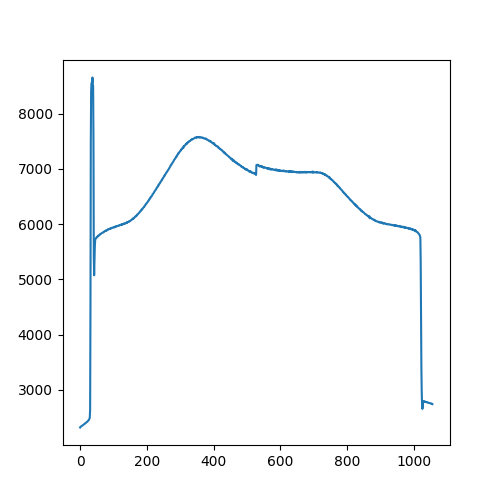

In [3]:
flatav = np.average(flat.data,axis=0)


fig1 = plt.figure(figsize=(5,5))
gs1 = GridSpec(figure=fig1,nrows=1,ncols=1)
ax1 = fig1.add_subplot(gs1[0])

ax1.plot(np.linspace(0,len(flatav),len(flatav)),flatav)



In [5]:
daofind = DAOStarFinder(brightest=121, fwhm=5,threshold=2)
daosources = daofind(grid.data)

daosources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,34.15080014370517,1028.0119045480433,0.32339548077542724,0.028654270825842213,0.03150058434195241,49,0.0,19453.0,9438.703646031765,-9.9372808760959
2,346.3261312181838,361.5888020302098,0.2567484689018398,-0.09129279611397652,0.004346178971443685,49,0.0,11016.0,5595.402755516626,-9.369578380960354
3,436.97685036122925,361.997217736323,0.2667393199789448,-0.007676729409168197,-0.02819767146982633,49,0.0,9909.0,5063.557050225906,-9.26113926866044
4,437.52780387010193,270.86489982087613,0.24801836199651722,-0.0602819090606275,0.04292873223511336,49,0.0,9432.0,4904.988391108398,-9.22659495962451
5,346.8181817082888,270.43518327835085,0.30247198921014395,-0.07171907757751653,0.0034093806449967375,49,0.0,9873.0,4860.193226658855,-9.216633839618453
6,345.9605105935533,452.64538706570164,0.207818610454551,0.00011337594617813777,0.012933195774524326,49,0.0,9394.0,4382.223394486388,-9.104236282513904
7,528.3200957151449,271.1882105203272,0.2540077986944668,0.0280376171776473,0.04149897831053856,49,0.0,8407.0,4223.9984847479045,-9.06430938433419
8,255.64242273148685,360.97057531507295,0.2219325125484148,-0.0011938019287537332,0.038186893570900035,49,0.0,8746.0,4011.7255449824456,-9.008328034713927
...,...,...,...,...,...,...,...,...,...,...


In [150]:
import Coord_Transform_Helpers as CTH


expected_sources = 121
fwhm = 5

mean_ccd, median_ccd, std_ccd = sigma_clipped_stats(grid.data, sigma=4.0)
        
#print(std_ccd)
#flip along y axis because I think ccd is reversed from dmd
grcopy = grid.copy()
grcopy.data = dbfgrid



iraffind = IRAFStarFinder(brightest=121, fwhm=5,threshold=2)
irafsources = iraffind(grid.data)

sortedirafs = CTH.sort_iraf_source_table(irafsources.to_pandas(),numcols=11)

sortedirafs

,index,id,xcentroid,ycentroid,fwhm,sharpness,roundness,pa,npix,sky,peak,flux,mag
0,80,81,76.176719,84.690172,3.291442,0.658288,0.023809,174.254981,34,3567.916667,2417.083333,48251.833333,-11.708785
1,67,68,166.880973,85.812640,3.342293,0.668459,0.033853,133.816626,37,3409.500000,2729.500000,55214.500000,-11.855133
2,59,60,257.628332,86.787087,3.341618,0.668324,0.040341,125.895253,34,3322.250000,2719.750000,57483.500000,-11.898858
3,50,51,348.181435,87.432405,3.323085,0.664617,0.069444,120.148747,33,3299.833333,2932.166667,59660.500000,-11.939217
4,46,47,438.832628,88.140163,3.368008,0.673602,0.008305,150.097025,36,3278.833333,2812.166667,60469.000000,-11.953832
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,111,112,478.069098,975.886709,3.423919,0.684784,0.070760,126.465949,23,9746.250000,528.750000,5340.250000,-9.318904
117,96,97,711.497715,998.407629,3.279519,0.655904,0.143154,135.633940,30,5377.583333,752.416667,12765.500000,-10.265095
118,91,92,803.248330,998.292513,3.411680,0.682336,0.039801,126.340351,31,4717.500000,1228.500000,26277.500000,-11.048960
119,88,89,895.119453,998.117591,3.394821,0.678964,0.035685,12.133611,35,4185.500000,1630.500000,36516.500000,-11.406223


In [151]:
sortedirafs[::-1]

,index,id,xcentroid,ycentroid,fwhm,sharpness,roundness,pa,npix,sky,peak,flux,mag
120,83,84,987.091092,997.816224,3.405234,0.681047,0.016335,173.518046,37,3821.916667,2096.083333,44625.083333,-11.623948
119,88,89,895.119453,998.117591,3.394821,0.678964,0.035685,12.133611,35,4185.500000,1630.500000,36516.500000,-11.406223
118,91,92,803.248330,998.292513,3.411680,0.682336,0.039801,126.340351,31,4717.500000,1228.500000,26277.500000,-11.048960
117,96,97,711.497715,998.407629,3.279519,0.655904,0.143154,135.633940,30,5377.583333,752.416667,12765.500000,-10.265095
116,111,112,478.069098,975.886709,3.423919,0.684784,0.070760,126.465949,23,9746.250000,528.750000,5340.250000,-9.318904
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,46,47,438.832628,88.140163,3.368008,0.673602,0.008305,150.097025,36,3278.833333,2812.166667,60469.000000,-11.953832
3,50,51,348.181435,87.432405,3.323085,0.664617,0.069444,120.148747,33,3299.833333,2932.166667,59660.500000,-11.939217
2,59,60,257.628332,86.787087,3.341618,0.668324,0.040341,125.895253,34,3322.250000,2719.750000,57483.500000,-11.898858
1,67,68,166.880973,85.812640,3.342293,0.668459,0.033853,133.816626,37,3409.500000,2729.500000,55214.500000,-11.855133


In [70]:
dmd

,target,x,y,dx1,dy1,dx2,dy2
0,slit1,40,40,3,3,3,3
1,slit2,140,40,3,3,3,3
2,slit3,240,40,3,3,3,3
3,slit4,340,40,3,3,3,3
4,slit5,440,40,3,3,3,3
...,...,...,...,...,...,...,...
116,slit117,640,1040,3,3,3,3
117,slit118,740,1040,3,3,3,3
118,slit119,840,1040,3,3,3,3
119,slit120,940,1040,3,3,3,3


In [173]:
reversed_irafs = []

for i in sortedirafs.index.values[::-11]:
    print(i)
    if i==sortedirafs.index.values[-1]:
        thisrow = sortedirafs[i-10:]
        
    else:
        midrow = thisrow
        thisrow = sortedirafs[i-10:i+1]
    
    #print(len(thisrow))

    if i==10:
        thisrow = sortedirafs[:i+1]
    
    reversed_irafs.append(thisrow)
    
    
reverses = pd.concat(reversed_irafs,).reset_index(drop=True)

reverses = reverses.drop(index=26).reset_index(drop=True)

reverses[40:60]

120
109
98
87
76
65
54
43
32
21
10


,index,id,xcentroid,ycentroid,fwhm,sharpness,roundness,pa,npix,sky,peak,flux,mag
40,73,74,801.681944,816.668086,3.383748,0.676750,0.045543,137.248359,31,4079.916667,2424.083333,52458.583333,-11.799541
41,61,62,893.171811,816.230211,3.384704,0.676941,0.012264,37.029649,33,3709.166667,2530.833333,56675.500000,-11.883488
42,62,63,984.989147,815.890045,3.391828,0.678366,0.014541,8.983802,37,3478.583333,2554.416667,56668.416667,-11.883353
43,114,115,173.700253,705.388194,3.562142,0.712428,0.168655,70.121429,22,8984.583333,578.416667,5130.166667,-9.275329
44,92,93,254.690143,634.264944,3.454308,0.690862,0.037117,11.248389,32,6071.333333,1141.666667,24469.333333,-10.971555
45,75,76,345.681568,634.752018,3.422122,0.684424,0.021766,154.907925,31,5381.083333,2225.916667,50347.416667,-11.754943
46,70,71,436.602278,634.956893,3.390656,0.678131,0.044742,175.283568,33,4747.416667,2491.583333,54208.250000,-11.835163
47,64,65,527.581755,635.111700,3.365780,0.673156,0.046886,20.316167,32,4488.750000,2628.250000,56504.000000,-11.880198
48,26,27,618.242719,635.134183,3.404885,0.680977,0.033092,162.873615,31,4346.583333,3167.416667,72823.916667,-12.155685
49,9,10,709.319602,635.062304,3.408678,0.681736,0.038582,3.477983,34,4250.083333,4380.916667,96286.166667,-12.458910


In [192]:
expected_sources = 121
fwhm = 5


        
#print(std_ccd)
#flip along y axis because I think ccd is reversed from dmd




iraffind_inv = IRAFStarFinder(brightest=100, fwhm=5,threshold=1)
irafsources_inv = iraffind_inv(grid.data)

sortedirafs_inv = CTH.sort_iraf_source_table(irafsources_inv.to_pandas(),numcols=11)



reversed_irafs_inv = []

for i in sortedirafs_inv.index.values[::-11]:
    print(i)
    if i==sortedirafs_inv.index.values[-1]:
        thisrow = sortedirafs_inv[i-10:]
        
    else:
        midrow = thisrow
        thisrow = sortedirafs_inv[i-10:i+1]
    
    #print(len(thisrow))

    if i==10:
        thisrow = sortedirafs_inv[:i+1]
    
    reversed_irafs_inv.append(thisrow)
    
inv_reverses = pd.concat(reversed_irafs_inv).reset_index(drop=True)



98
87
76
65
54
43
32
21
10


<IPython.core.display.Javascript object>


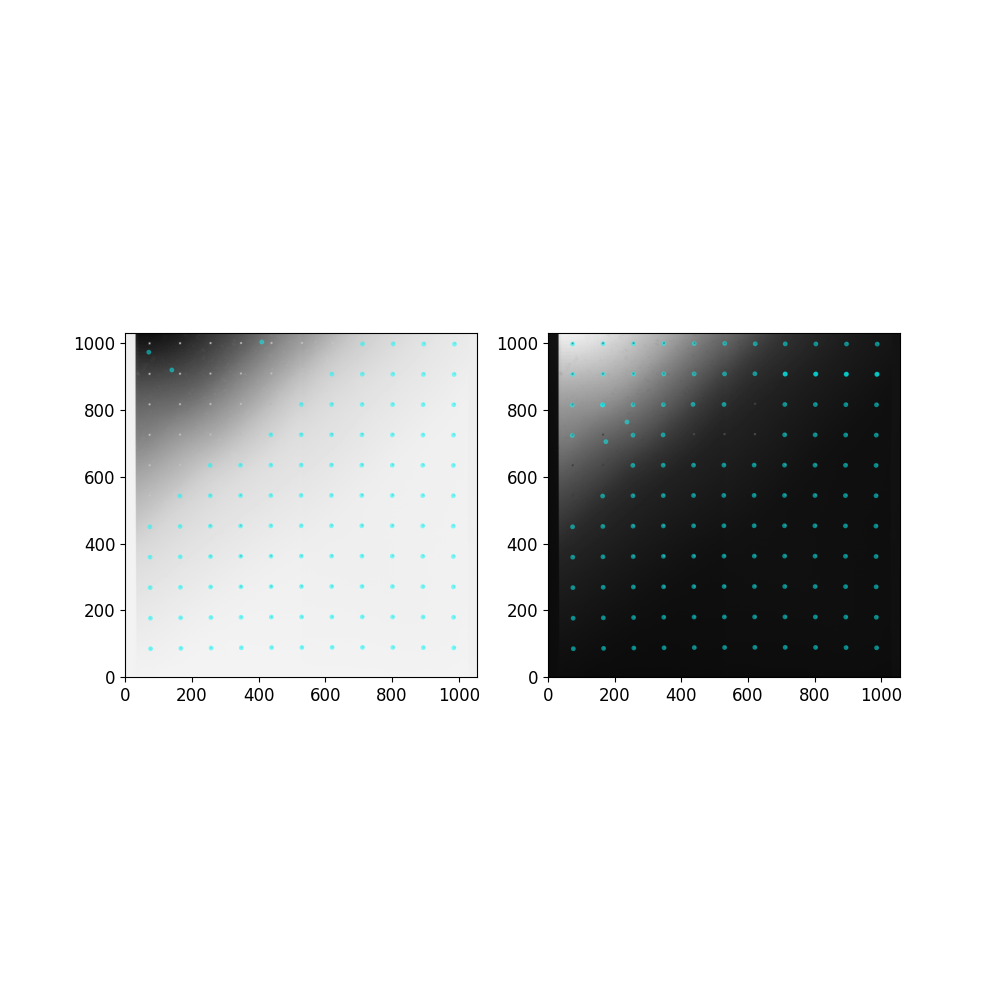

In [193]:
from photutils.aperture import CircularAperture, EllipticalAperture



fig2 = plt.figure(figsize=(10,10))
gs2 = GridSpec(figure=fig2,nrows=1,ncols=2)
ax2a = fig2.add_subplot(gs2[0])
ax2b = fig2.add_subplot(gs2[1])

ax2a.imshow(invgrid,norm=None,cmap="gray", origin='lower')


iraf_positions_inv = np.transpose((inv_reverses['xcentroid'], inv_reverses['ycentroid']))

apertures_ccd_inv = CircularAperture(iraf_positions_inv, r=4.)

ap_plots_inv = apertures_ccd_inv.plot(ax2a,color='cyan', lw=1.5, alpha=0.5)


ax2b.imshow(grid,norm=None,cmap="gray",origin="lower")
iraf_positions = np.transpose((reverses_copy['xcentroid'], reverses_copy['ycentroid']))

apertures_ccd = CircularAperture(iraf_positions, r=4.)

ap_plots = apertures_ccd.plot(ax2b,color='cyan', lw=1.5, alpha=0.5)



In [257]:
#row4 = inv_reverses.copy()
inv_reverses.sort_values(by='ycentroid')[15:30]

,index,id,xcentroid,ycentroid,fwhm,sharpness,roundness,pa,npix,sky,peak,flux,mag
80,35,36,347.353974,179.078619,3.357921,0.671584,0.022074,154.989720,34,3488.583333,3026.416667,67312.166667,-12.070234
86,66,67,892.983593,179.614925,3.343522,0.668704,0.016566,101.596405,34,3409.916667,2715.083333,55889.833333,-11.868332
81,19,20,438.100288,179.666743,3.381963,0.676393,0.022862,81.602576,34,3569.333333,3736.666667,81834.666667,-12.282343
85,48,49,801.742388,179.880782,3.399145,0.679829,0.023238,159.959377,34,3399.416667,2741.583333,60401.833333,-11.952625
82,24,25,528.872027,179.934555,3.379629,0.675926,0.023693,99.622178,37,3494.166667,3442.833333,76781.833333,-12.213146
83,33,34,619.702588,180.074617,3.371358,0.674272,0.012576,21.185275,34,3480.916667,3034.083333,69286.833333,-12.101627
84,41,42,710.656423,180.080029,3.382021,0.676404,0.009588,15.896402,34,3425.916667,2908.083333,61839.833333,-11.978171
66,87,88,74.903033,267.768397,3.380552,0.676110,0.029990,91.662621,35,4173.833333,1801.166667,39315.833333,-11.486419
67,79,80,165.672707,268.875162,3.354068,0.670814,0.038426,140.306173,34,3946.416667,2265.583333,48510.833333,-11.714597
68,28,29,256.183841,269.785967,3.375816,0.675163,0.018703,72.390036,33,3901.333333,3212.666667,71475.000000,-12.135385


In [258]:
reverses_copy = reverses.copy()


reverses.loc[0,["xcentroid","ycentroid"]] = 73.9809,997.96
reverses.loc[1,["xcentroid","ycentroid"]] = 165.091,998.9
reverses.loc[2,["xcentroid","ycentroid"]] = 256.056,998.9
reverses.loc[3,["xcentroid","ycentroid"]] = 347.563,999.515
reverses.loc[4,["xcentroid","ycentroid"]] = 438.502,999.486
reverses.loc[5,["xcentroid","ycentroid"]] = 530.013,999.864
reverses.loc[6,["xcentroid","ycentroid"]] = 621.55,998.7

reverses.loc[11,["xcentroid","ycentroid"]] = 74.0707, 907.015 
reverses.loc[12,["xcentroid","ycentroid"]] = 165.074, 907.89
reverses.loc[13,["xcentroid","ycentroid"]] = 256.485, 908.04
reverses.loc[14,["xcentroid","ycentroid"]] = 347.463, 908.506
reverses.loc[15,["xcentroid","ycentroid"]] = 438.429, 908.507
reverses.loc[16,["xcentroid","ycentroid"]] = 529.532, 908.498
reverses.loc[17,["xcentroid","ycentroid"]] = 620.537, 908.979
reverses.loc[18,["xcentroid","ycentroid"]] = 711.52, 908.496
reverses.loc[19,["xcentroid","ycentroid"]] = 803.528, 908.472
reverses.loc[20,["xcentroid","ycentroid"]] = 894.994, 908.011
reverses.loc[21,["xcentroid","ycentroid"]] = 986.986, 907.946


reverses.loc[22, ["xcentroid", "ycentroid"]] = row345.loc[1,["xcentroid", "ycentroid"]]
reverses.loc[23, ["xcentroid", "ycentroid"]] = row345.loc[4,["xcentroid", "ycentroid"]]
reverses.loc[24, ["xcentroid", "ycentroid"]] = row345.loc[8,["xcentroid", "ycentroid"]]
reverses.loc[25, ["xcentroid", "ycentroid"]] = row345.loc[10,["xcentroid", "ycentroid"]]
reverses.loc[28, ["xcentroid", "ycentroid"]] = 618.9, 816.884345
reverses.loc[29, ["xcentroid", "ycentroid"]] = row4.loc[17,["xcentroid", "ycentroid"]]
reverses.loc[30, ["xcentroid", "ycentroid"]] = row4.loc[18,["xcentroid", "ycentroid"]]
reverses.loc[31, ["xcentroid", "ycentroid"]] = row4.loc[19,["xcentroid", "ycentroid"]]
reverses.loc[32, ["xcentroid", "ycentroid"]] = row4.loc[20,["xcentroid", "ycentroid"]]




reverses.loc[33,["xcentroid", "ycentroid"]] = row345.loc[2,["xcentroid", "ycentroid"]]
reverses.loc[34,["xcentroid", "ycentroid"]] = row345.loc[5,["xcentroid", "ycentroid"]]
reverses.loc[35,["xcentroid", "ycentroid"]] = row345.loc[9,["xcentroid", "ycentroid"]]
reverses.loc[36,["xcentroid", "ycentroid"]] = 345.3, 725.6
reverses.loc[37,["xcentroid", "ycentroid"]] = row4.loc[11,["xcentroid", "ycentroid"]]
reverses.loc[38,["xcentroid", "ycentroid"]] = row4.loc[12,["xcentroid", "ycentroid"]]
reverses.loc[39,["xcentroid", "ycentroid"]] = row4.loc[14,["xcentroid", "ycentroid"]]
reverses.loc[40,["xcentroid", "ycentroid"]] = row4.loc[16,["xcentroid", "ycentroid"]]
reverses.loc[41,["xcentroid", "ycentroid"]] = row4.loc[29,["xcentroid", "ycentroid"]]
reverses.loc[42,["xcentroid", "ycentroid"]] = row4.loc[31,["xcentroid", "ycentroid"]]
reverses.loc[43,["xcentroid", "ycentroid"]] = row4.loc[32,["xcentroid", "ycentroid"]]




reverses.loc[44,["xcentroid", "ycentroid"]] = row345.loc[3,["xcentroid", "ycentroid"]]
reverses.loc[45,["xcentroid", "ycentroid"]] = row345.loc[7,["xcentroid", "ycentroid"]]
reverses.loc[46,["xcentroid", "ycentroid"]] = row4.loc[22,["xcentroid", "ycentroid"]]
reverses.loc[47,["xcentroid", "ycentroid"]] = row4.loc[23,["xcentroid", "ycentroid"]]
reverses.loc[48,["xcentroid", "ycentroid"]] = row4.loc[24,["xcentroid", "ycentroid"]]
reverses.loc[49,["xcentroid", "ycentroid"]] = row4.loc[25,["xcentroid", "ycentroid"]]
reverses.loc[50,["xcentroid", "ycentroid"]] = row4.loc[26,["xcentroid", "ycentroid"]]
reverses.loc[51,["xcentroid", "ycentroid"]] = row4.loc[27,["xcentroid", "ycentroid"]]
reverses.loc[52,["xcentroid", "ycentroid"]] = row4.loc[28,["xcentroid", "ycentroid"]]
reverses.loc[53,["xcentroid", "ycentroid"]] = row4.loc[30,["xcentroid", "ycentroid"]]
reverses.loc[54,["xcentroid", "ycentroid"]] = row4.loc[43,["xcentroid", "ycentroid"]]





reverses.loc[55,["xcentroid", "ycentroid"]] = 73.51, 542.47
reverses.loc[56,["xcentroid", "ycentroid"]] = row4.loc[33,["xcentroid", "ycentroid"]]
reverses.loc[57,["xcentroid", "ycentroid"]] = row4.loc[34,["xcentroid", "ycentroid"]]
reverses.loc[58,["xcentroid", "ycentroid"]] = row4.loc[35,["xcentroid", "ycentroid"]]
reverses.loc[59,["xcentroid", "ycentroid"]] = row4.loc[36,["xcentroid", "ycentroid"]]
reverses.loc[60,["xcentroid", "ycentroid"]] = row4.loc[37,["xcentroid", "ycentroid"]]
reverses.loc[61,["xcentroid", "ycentroid"]] = row4.loc[38,["xcentroid", "ycentroid"]]
reverses.loc[62,["xcentroid", "ycentroid"]] = row4.loc[39,["xcentroid", "ycentroid"]]
reverses.loc[63,["xcentroid", "ycentroid"]] = row4.loc[40,["xcentroid", "ycentroid"]]
reverses.loc[64,["xcentroid", "ycentroid"]] = row4.loc[41,["xcentroid", "ycentroid"]]
reverses.loc[65,["xcentroid", "ycentroid"]] = row4.loc[42,["xcentroid", "ycentroid"]]




reverses.loc[66,["xcentroid", "ycentroid"]] = row4.loc[44,["xcentroid", "ycentroid"]]
reverses.loc[67,["xcentroid", "ycentroid"]] = row4.loc[45,["xcentroid", "ycentroid"]]
reverses.loc[68,["xcentroid", "ycentroid"]] = row4.loc[46,["xcentroid", "ycentroid"]]
reverses.loc[69,["xcentroid", "ycentroid"]] = row4.loc[47,["xcentroid", "ycentroid"]]
reverses.loc[70,["xcentroid", "ycentroid"]] = row4.loc[48,["xcentroid", "ycentroid"]]
reverses.loc[71,["xcentroid", "ycentroid"]] = row4.loc[49,["xcentroid", "ycentroid"]]
reverses.loc[72,["xcentroid", "ycentroid"]] = row4.loc[50,["xcentroid", "ycentroid"]]
reverses.loc[73,["xcentroid", "ycentroid"]] = row4.loc[51,["xcentroid", "ycentroid"]]
reverses.loc[74,["xcentroid", "ycentroid"]] = row4.loc[52,["xcentroid", "ycentroid"]]
reverses.loc[75,["xcentroid", "ycentroid"]] = row4.loc[53,["xcentroid", "ycentroid"]]
reverses.loc[76,["xcentroid", "ycentroid"]] = row4.loc[54,["xcentroid", "ycentroid"]]



reverses.loc[77,["xcentroid", "ycentroid"]] = row4.loc[55,["xcentroid", "ycentroid"]]
reverses.loc[78,["xcentroid", "ycentroid"]] = row4.loc[56,["xcentroid", "ycentroid"]]
reverses.loc[79,["xcentroid", "ycentroid"]] = row4.loc[57,["xcentroid", "ycentroid"]]
reverses.loc[80,["xcentroid", "ycentroid"]] = row4.loc[58,["xcentroid", "ycentroid"]]
reverses.loc[81,["xcentroid", "ycentroid"]] = row4.loc[59,["xcentroid", "ycentroid"]]
reverses.loc[82,["xcentroid", "ycentroid"]] = row4.loc[60,["xcentroid", "ycentroid"]]
reverses.loc[83,["xcentroid", "ycentroid"]] = row4.loc[61,["xcentroid", "ycentroid"]]
reverses.loc[84,["xcentroid", "ycentroid"]] = row4.loc[62,["xcentroid", "ycentroid"]]
reverses.loc[85,["xcentroid", "ycentroid"]] = row4.loc[63,["xcentroid", "ycentroid"]]
reverses.loc[86,["xcentroid", "ycentroid"]] = row4.loc[64,["xcentroid", "ycentroid"]]
reverses.loc[87,["xcentroid", "ycentroid"]] = row4.loc[65,["xcentroid", "ycentroid"]]


reverses.loc[88,["xcentroid", "ycentroid"]] = row4.loc[66,["xcentroid", "ycentroid"]]
reverses.loc[89,["xcentroid", "ycentroid"]] = row4.loc[67,["xcentroid", "ycentroid"]]
reverses.loc[90,["xcentroid", "ycentroid"]] = row4.loc[68,["xcentroid", "ycentroid"]]
reverses.loc[91,["xcentroid", "ycentroid"]] = row4.loc[69,["xcentroid", "ycentroid"]]
reverses.loc[92,["xcentroid", "ycentroid"]] = row4.loc[70,["xcentroid", "ycentroid"]]
reverses.loc[93,["xcentroid", "ycentroid"]] = row4.loc[71,["xcentroid", "ycentroid"]]
reverses.loc[94,["xcentroid", "ycentroid"]] = row4.loc[72,["xcentroid", "ycentroid"]]
reverses.loc[95,["xcentroid", "ycentroid"]] = row4.loc[73,["xcentroid", "ycentroid"]]
reverses.loc[96,["xcentroid", "ycentroid"]] = row4.loc[74,["xcentroid", "ycentroid"]]
reverses.loc[97,["xcentroid", "ycentroid"]] = row4.loc[75,["xcentroid", "ycentroid"]]
reverses.loc[98,["xcentroid", "ycentroid"]] = row4.loc[76,["xcentroid", "ycentroid"]]




reverses.loc[99,["xcentroid", "ycentroid"]] = row4.loc[77,["xcentroid", "ycentroid"]]
reverses.loc[100,["xcentroid", "ycentroid"]] = row4.loc[78,["xcentroid", "ycentroid"]]
reverses.loc[101,["xcentroid", "ycentroid"]] = row4.loc[79,["xcentroid", "ycentroid"]]
reverses.loc[102,["xcentroid", "ycentroid"]] = row4.loc[80,["xcentroid", "ycentroid"]]
reverses.loc[103,["xcentroid", "ycentroid"]] = row4.loc[81,["xcentroid", "ycentroid"]]
reverses.loc[104,["xcentroid", "ycentroid"]] = row4.loc[82,["xcentroid", "ycentroid"]]
reverses.loc[105,["xcentroid", "ycentroid"]] = row4.loc[83,["xcentroid", "ycentroid"]]
reverses.loc[106,["xcentroid", "ycentroid"]] = row4.loc[84,["xcentroid", "ycentroid"]]
reverses.loc[107,["xcentroid", "ycentroid"]] = row4.loc[85,["xcentroid", "ycentroid"]]
reverses.loc[108,["xcentroid", "ycentroid"]] = row4.loc[86,["xcentroid", "ycentroid"]]
reverses.loc[109,["xcentroid", "ycentroid"]] = row4.loc[87,["xcentroid", "ycentroid"]]




reverses.loc[110,["xcentroid", "ycentroid"]] = row4.loc[88,["xcentroid", "ycentroid"]]
reverses.loc[111,["xcentroid", "ycentroid"]] = row4.loc[89,["xcentroid", "ycentroid"]]
reverses.loc[112,["xcentroid", "ycentroid"]] = row4.loc[90,["xcentroid", "ycentroid"]]
reverses.loc[113,["xcentroid", "ycentroid"]] = row4.loc[91,["xcentroid", "ycentroid"]]
reverses.loc[114,["xcentroid", "ycentroid"]] = row4.loc[92,["xcentroid", "ycentroid"]]
reverses.loc[115,["xcentroid", "ycentroid"]] = row4.loc[93,["xcentroid", "ycentroid"]]
reverses.loc[116,["xcentroid", "ycentroid"]] = row4.loc[94,["xcentroid", "ycentroid"]]
reverses.loc[117,["xcentroid", "ycentroid"]] = row4.loc[95,["xcentroid", "ycentroid"]]
reverses.loc[118,["xcentroid", "ycentroid"]] = row4.loc[96,["xcentroid", "ycentroid"]]
reverses.loc[119,["xcentroid", "ycentroid"]] = row4.loc[97,["xcentroid", "ycentroid"]]
reverses.loc[120,["xcentroid", "ycentroid"]] = row4.loc[98,["xcentroid", "ycentroid"]]











reverses_copy.sort_values(by="ycentroid")[55:75]

,index,id,xcentroid,ycentroid,fwhm,sharpness,roundness,pa,npix,sky,peak,flux,mag
55,39,40,73.510000,542.470000,3.371198,0.674240,0.025228,68.506024,34,5257.500000,2877.500000,62236.000000,-11.985104
57,47,48,254.992207,543.175614,3.387269,0.677454,0.038362,6.285179,34,4301.416667,2682.583333,60455.833333,-11.953596
65,95,96,983.635060,543.213434,3.377343,0.675469,0.029122,42.861039,34,5313.666667,833.333333,16662.333333,-10.554340
64,52,53,891.919883,543.738774,3.389324,0.677865,0.015094,2.850158,34,3445.000000,2695.000000,59452.000000,-11.935416
58,51,52,345.824353,543.743066,3.407466,0.681493,0.039765,152.250008,31,4075.666667,2784.333333,59538.333333,-11.936992
59,32,33,436.608553,544.009693,3.387299,0.677460,0.021270,130.536847,31,3961.333333,3159.666667,70171.666667,-12.115404
63,49,50,800.613550,544.020761,3.372871,0.674574,0.040795,4.141322,31,3437.500000,2720.500000,59786.500000,-11.941508
60,13,14,527.306156,544.165372,3.409585,0.681917,0.033266,144.554523,31,3984.166667,4166.833333,90999.833333,-12.397601
62,38,39,709.244797,544.197775,3.381265,0.676253,0.027412,104.527402,34,3494.750000,2768.250000,62433.500000,-11.988544
61,15,16,618.215814,544.245170,3.384295,0.676859,0.057603,0.777246,34,3856.000000,3734.000000,84870.000000,-12.321886


In [264]:
dmdccd_tab = pd.concat([reverses[["id","xcentroid","ycentroid"]].reset_index(drop=True),dmd],axis=1)
dmdccd_tab.loc[120,"id"] = 121

#dmdccd_tab.to_csv("tab_pix_to_dmd_coords.csv",index=False)
dmdccd_tab

,id,xcentroid,ycentroid,target,x,y,dx1,dy1,dx2,dy2
0,1.0,73.980900,997.960000,slit1,40,40,3,3,3,3
1,104.0,165.091000,998.900000,slit2,140,40,3,3,3,3
2,100.0,256.056000,998.900000,slit3,240,40,3,3,3,3
3,120.0,347.563000,999.515000,slit4,340,40,3,3,3,3
4,113.0,438.502000,999.486000,slit5,440,40,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...
116,56.0,620.304611,88.758784,slit117,640,1040,3,3,3,3
117,66.0,711.284618,88.743500,slit118,740,1040,3,3,3,3
118,70.0,802.341492,88.600486,slit119,840,1040,3,3,3,3
119,75.0,893.749619,88.055289,slit120,940,1040,3,3,3,3


In [278]:
from astropy.wcs.utils import fit_wcs_from_points
from astropy.coordinates import SkyCoord
import astropy.units as u


dmd_skycoods = SkyCoord(dmd.x.values*u.arcsecond,dmd.y.values*u.arcsecond,unit='deg')

ccdcoords = reverses[["xcentroid","ycentroid"]].values
ccd_to_dmd_wcs = fit_wcs_from_points(xy=ccdcoords.T,world_coords=dmd_skycoods, sip_degree=3)

mapfits = ccd_to_dmd_wcs.to_fits()

#mapfits.writeto("DMD_Mapping_WCS.fits",overwrite=False)

In [275]:
coords = ccd_to_dmd_wcs.all_pix2world(ccdcoords,0)
dmdx, dmdy = coords[:,0]*3600, coords[:,0]*3600

dmdx,dmdy

(array([  39.72979179,  139.69369446,  239.55483969,  340.01706524,
         439.83885734,  540.2231603 ,  640.5602445 ,  739.01457747,
         839.27079828,  939.45193546, 1039.49960466,   40.42629277,
         140.36946309,  240.81193292,  340.78727075,  440.72818317,
         540.75888228,  640.57969063,  740.25404309,  840.87423952,
         940.69949316, 1040.84731574,   39.62808439,  139.73174158,
         239.82630552,  339.95664363,  437.73362518,  539.76237186,
         639.65501682,  739.7275372 ,  839.87870275,  939.80853368,
        1039.84922575,   39.90193075,  140.00685239,  240.2068031 ,
         339.41212696,  439.89316065,  540.01571835,  639.99084566,
         739.9280194 ,  839.89425937,  940.0253013 , 1039.88931495,
          40.00367701,  140.2212181 ,  239.77187819,  339.98702634,
         440.09629577,  540.20633423,  639.86673461,  739.84876084,
         840.02772131,  939.97099729, 1039.99715368,   40.06102381,
         139.81443526,  239.99820468,  340.09512

In [248]:
reverses

,index,id,xcentroid,ycentroid,fwhm,sharpness,roundness,pa,npix,sky,peak,flux,mag
0,0,1,73.980900,997.960000,3.394700,0.678940,0.175511,60.196101,30,8024.583333,12891.416667,284272.500000,-13.634337
1,103,104,165.091000,998.900000,3.181085,0.636217,0.035985,126.653477,17,20070.833333,1082.166667,6062.833333,-9.456689
2,99,100,256.056000,998.900000,3.409077,0.681815,0.178380,174.735395,22,19072.583333,1166.416667,8089.166667,-9.769759
3,119,120,347.563000,999.515000,3.078359,0.615672,0.083262,122.886531,20,13689.000000,516.000000,4964.000000,-9.239579
4,112,113,438.502000,999.486000,3.270567,0.654113,0.169963,47.433146,19,14669.250000,679.750000,5316.250000,-9.314013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,43,44,620.304611,88.758784,3.363429,0.672686,0.026953,67.165462,31,3347.916667,2847.083333,61093.583333,-11.964989
116,55,56,711.284618,88.743500,3.350246,0.670049,0.013049,49.191961,31,3369.333333,2854.666667,58432.666667,-11.916639
117,65,66,802.341492,88.600486,3.341478,0.668296,0.041637,51.015579,31,3343.000000,2601.000000,56013.000000,-11.870722
118,69,70,893.749619,88.055289,3.374663,0.674933,0.009919,114.045919,37,3349.916667,2533.083333,54441.083333,-11.839817
